# A notebook to carry out calculations

This notebook accompanies the work described in the article **An evolutionary game theory model for devaluing rhinos**.
It is used for generating plots and analysing data and verify some of the algebra, all described in the paper.

In [1]:
import sympy as sym
import scipy as sp
import numpy as np
import pandas as pd
sym.init_printing()

import imp
tools = imp.load_source('tools', '../tools.py')

assert sym.__version__ == "1.0"
assert sp.__version__ == "0.19.0"
assert np.__version__ == "1.12.1"

In [2]:
#import matplotlib
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

font = {'size'   : 15,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [3]:
from scipy.optimize import brentq
from scipy.integrate import odeint

Defining all our variables (with assumption that they are positive).

In [4]:
r, s, x, theta_r, alpha, H, beta, Gamma, F, tau, N_r  = sym.symbols("r, s, x, theta_r, alpha, \
                                                                   H, beta, Gamma, F, tau, N_r", positive=True)

The model
----------

In [5]:
# the theta function
tools.theta(r, s)

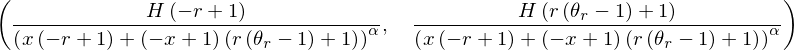

In [6]:
# gain
tools.gain(1), tools.gain(0)

In [7]:
rs = np.linspace(0, 0.999, 100)

In [8]:
gain = sym.lambdify((H, r, theta_r, x, alpha), 
                    H * tools.theta(r=r, s=x, theta_r=theta_r) ** -alpha)

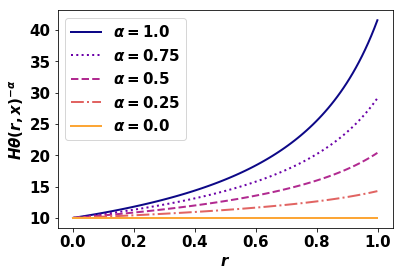

In [9]:
fig =  plt.figure();     
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-']
for i, alphas in enumerate(np.linspace(1, 0, 5)):
    ys = [gain(10, rval, 0.3, 0.2, alphas) for rval in rs]
    c = next(colors)
    
    plt.plot(rs, ys, label=r'$\alpha={}$'.format(alphas), linestyle=linestyles[i], 
             linewidth=2, color=c)
plt.ylabel(r'$H\theta(r, x)^{-\alpha}$')
plt.xlabel(r'$r$')

plt.legend()
plt.savefig('../images/gain_curve.pdf', bbox_inches='tight')

# Cost

Here we simulate time spent in the park to offer an empirical verification of the obtained formula.

In [10]:
import random
import math

def simulate_count_of_devalued_rhinos(r_val):
    count = 0
    while random.random() < r_val:
        count += 1
    return count

def simulate_selective_time(r_val, tau_val, repetitions=500):
    times = []
    for seed in range(repetitions):
        random.seed(seed)
        devalued_rhinos_count = simulate_count_of_devalued_rhinos(r_val)
        times.append(devalued_rhinos_count + tau_val)
    return times
        
def simulate_indiscriminate_time(r_val, tau_val, repetitions=500):
    times = []
    N_r = math.ceil(1 / theta_r_val)
    for seed in range(repetitions):
        random.seed(seed)
        devalued_rhinos_count = simulate_count_of_devalued_rhinos(r_val)
        times.append(min(N_r, devalued_rhinos_count + 1) * tau_val)
    return times

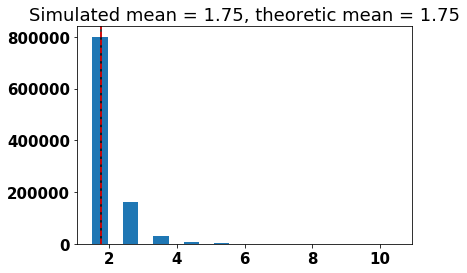

In [11]:
r_val=.2
tau_val= 1.5
repetitions = 10 ** 6

simulated_values = simulate_selective_time(r_val=r_val, tau_val=tau_val, repetitions=repetitions)
simulated_mean = np.mean(simulated_values)
theoretic_mean = tools.selective_time(r=r_val, tau=tau_val)
plt.hist(simulated_values, bins=20)
plt.axvline(simulated_mean, color="black")
plt.axvline(theoretic_mean, color="red", linestyle="dashed")
plt.title("Simulated mean = {:.02f}, theoretic mean = {:.02f}".format(simulated_mean, theoretic_mean))

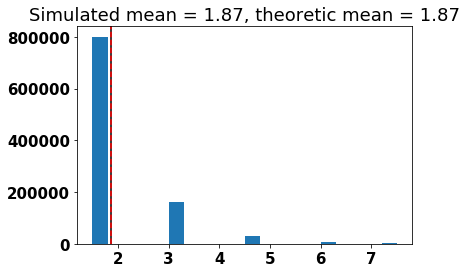

In [12]:
theta_r_val = .2
N_r_val = math.ceil(1 / theta_r_val)

repetitions = 10 ** 6
simulated_values = simulate_indiscriminate_time(r_val=r_val, 
                                                tau_val=tau_val,
                                                repetitions=repetitions)
simulated_mean = np.mean(simulated_values)
theoretic_mean = tools.indiscriminate_time(r=r_val, tau=tau_val, N_r=N_r_val)
plt.hist(simulated_values, bins=20)
plt.axvline(simulated_mean, color="black")
plt.axvline(theoretic_mean, color="red", linestyle="dashed")
plt.title("Simulated mean = {:.02f}, theoretic mean = {:.02f}".format(simulated_mean, theoretic_mean))

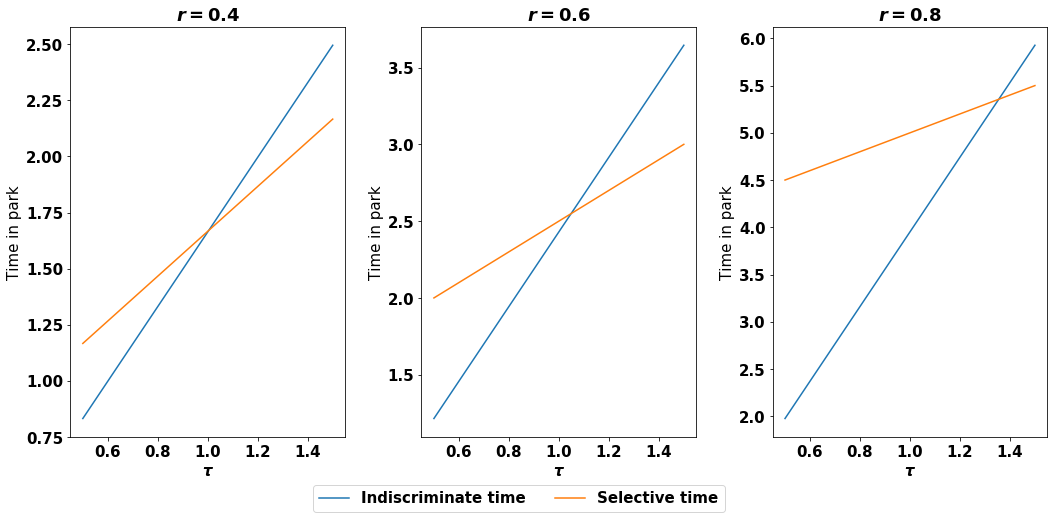

In [61]:
taus = np.linspace(.5, 1.5, 100)
theta_r_val = .15

fig, axarr = plt.subplots(1, 3, figsize=(15, 7))

for i, r_val in enumerate((.4, .6, .8)):
    N_r_val = math.ceil(1 / theta_r_val)

    ax = axarr[i]
    ax.plot(taus, [tools.indiscriminate_time(r=r_val, tau=tau, N_r=N_r_val) for tau in taus], label="Indiscriminate time")
    ax.plot(taus, [tools.selective_time(r=r_val, tau=tau) for tau in taus], label="Selective time")
    ax.set_xlabel("$\\tau$")
    ax.set_ylabel("Time in park")
    ax.set_title("$r={}$".format(r_val))
    
ax.legend(bbox_to_anchor=(-1.7, -.2, 1., .102), loc="lower left",
          ncol=2)

fig.tight_layout()
fig.savefig("../images/indiscriminate_vs_selective_time.pdf", bbox_inches="tight")

In [38]:
F_val = 5
r_val = 0.4
theta_r_val = 0.15

../tools.py:70: RuntimeWarning: invalid value encountered in double_scalars
  * (


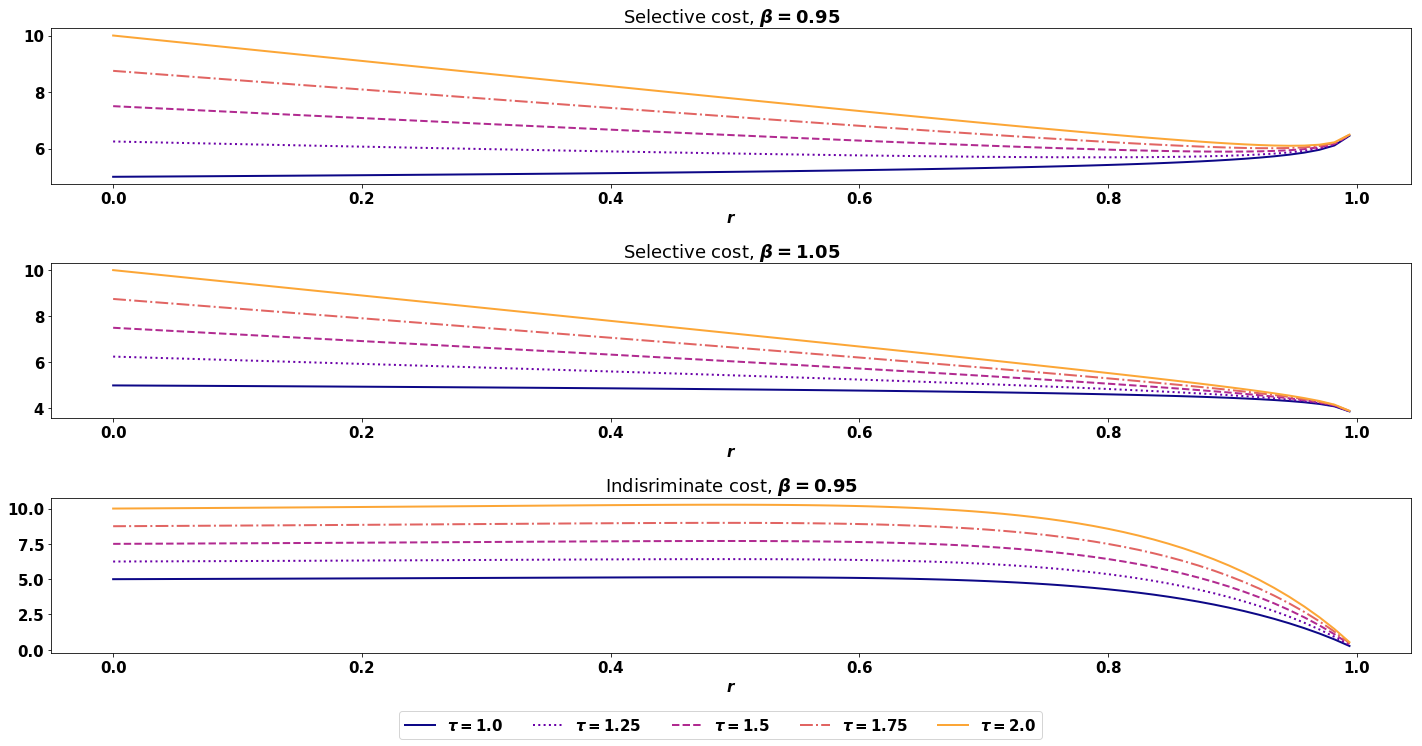

In [48]:
betas = (.95, .99, 1.05)
fig, axarr =  plt.subplots(len(betas), 1, figsize=(20,10))
for plot_index, (beta_val, s_val) in enumerate(((.95, 1), (1.05, 1), (.95, 0))):
    tpe = "Selective" if s_val == 1 else "Indisriminate"
    colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
    linestyles = ['-', ':', '--', '-.', '-']
    for i, tau_val in enumerate(np.linspace(1, 2, 5)):
        ys = [tools.cost(s=s_val,
                         r=rval, 
                         tau=tau_val,
                         theta_r=theta_r_val, 
                         F=F_val,
                         beta=beta_val)
              for rval in rs]
        c = next(colors)

        ax = axarr[plot_index]
        ax.plot(rs, ys, label='$\\tau={}$'.format(tau_val), linestyle=linestyles[i], 
                            linewidth=2, color=c)
        ax.set_xlabel(r'$r$')
        ax.set_title("{} cost, $\\beta={}$".format(tpe, beta_val))

ax.legend(bbox_to_anchor=(0.25, -.6, 1., .102), loc="lower left",
          ncol=5)
fig.tight_layout()
fig.savefig('../images/betas_curve.pdf', bbox_inches='tight')

Utility
-------

One the cost and the gain of a poacher have been defined we bring all together in the utility function.

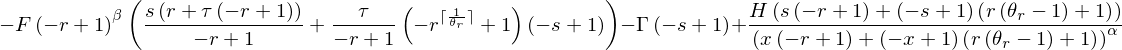

In [18]:
tools.utility()

Here we verify that how we write the utility in the paper is in line with our code.

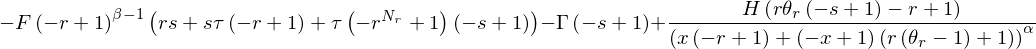

In [19]:
expr = H * (theta_r * r * (1 - s) - r + 1) * tools.theta(r, x) ** (-alpha) - \
       F * (s * r + s * tau * (1 - r) + (1 - s) * tau * (1 - r ** (N_r))) * (1 - r) ** (beta - 1) - Gamma * (1 - s)
expr

In [20]:
(tools.utility() - expr).subs({N_r: sym.ceiling(1 / theta_r)}).simplify()

# Observing the system

Solve the differential equations numerically and observe the outcomes:

In [21]:
def dx(x_1, t, F_v, H_v, r_v, alpha_v, beta_v, tau_v, theta_r_v, Gamma=0):
    """
    Define the derivate of x
    """

    x_1 = x_1[0]
    f_1 = tools.utility(s=1, x=x_1, F=F_v, H=H_v, r=r_v,
                        alpha=alpha_v, beta=beta_v, tau=tau_v, theta_r=theta_r_v)
    f_2 = tools.utility(s=0, x=x_1, F=F_v, H=H_v, r=r_v,
                        alpha=alpha_v, beta=beta_v, tau=tau_v, theta_r=theta_r_v, Gamma=Gamma)
    
    return x_1 * (1 - x_1) * (f_1 - f_2)

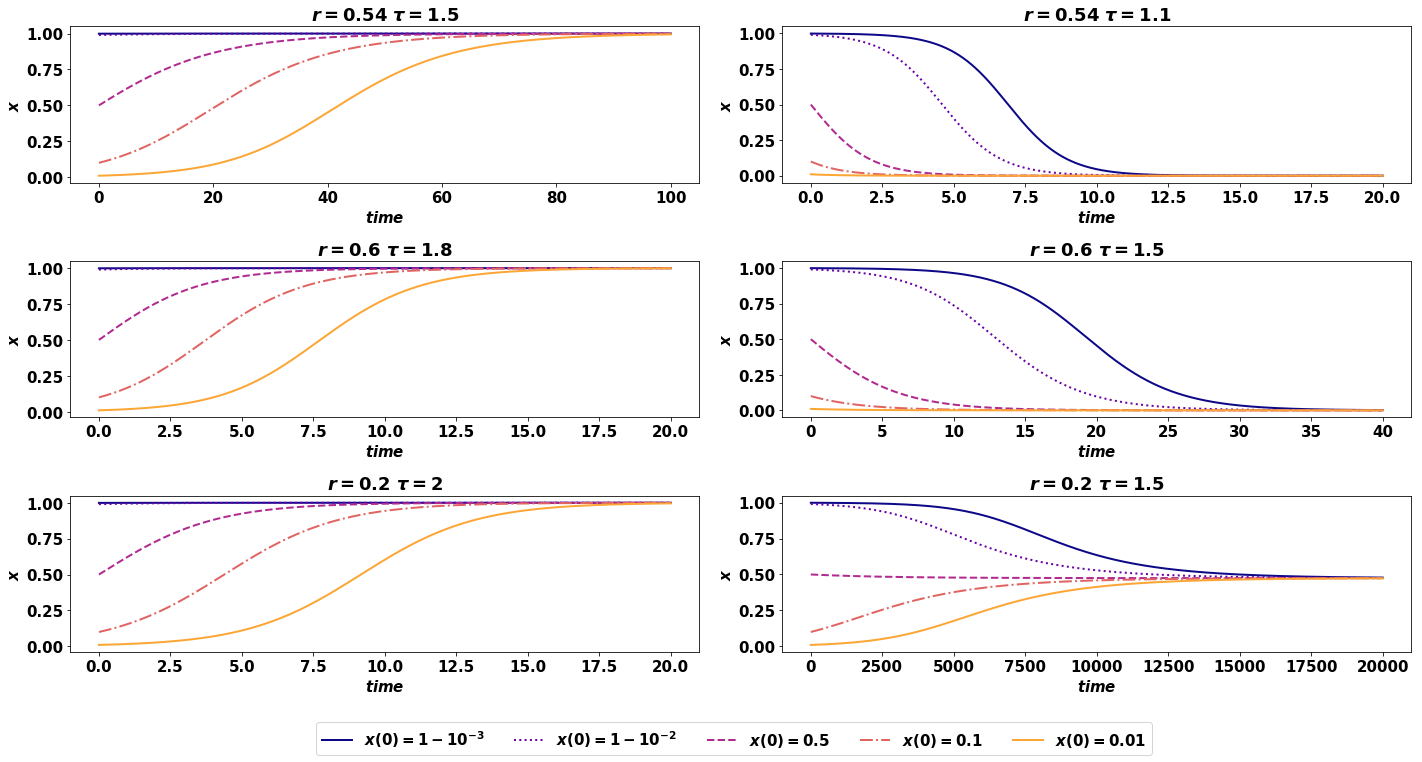

In [22]:
fig, axarr =  plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
tss = [np.linspace(0, 100, 1000), 
       np.linspace(0, 20, 1000),
       np.linspace(0, 20, 1000), 
       np.linspace(0, 40, 1000), 
       np.linspace(0, 20, 1000), 
       np.linspace(0, 20000, 1000),
      ]
linestyles = ['-', ':', '--', '-.', '-', ':']
labels = ["0.01", "0.1", "0.5", "1-10^{-2}", "1-10^{-3}"][::-1]
starting_populations = [.01, .1, .5, .99, .999][::-1]
scenarios = [{"F_v": 5, "H_v": 50, "r": 0.54, "alpha_v": 2, "beta_v": .99, "tau": 1.5, "theta_r": 0.01}, 
             {"F_v": 5, "H_v": 50, "r": 0.54, "alpha_v": 2, "beta_v": .99, "tau": 1.1, "theta_r": 0.01},
             {"F_v": 5, "H_v": 50, "r": 0.6, "alpha_v": 2, "beta_v": .99, "tau": 1.8, "theta_r": 0.01}, 
             {"F_v": 5, "H_v": 50, "r": 0.6, "alpha_v": 2, "beta_v": .99, "tau": 1.5, "theta_r": 0.01}, 
             {"F_v": 5, "H_v": 192, "r":.2, "alpha_v":1.2,  "beta_v": .99, "tau":2, "theta_r": .01},
             {"F_v": 5, "H_v": 192, "r":.2, "alpha_v":1.2,  "beta_v": .99, "tau":1.5, "theta_r": .01}, 
            ]

for i, scenario, ts in zip(range(len(scenarios)), scenarios, tss):
    colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
    for linestyle, starting_population, label in zip(linestyles, 
                                                 starting_populations,
                                                 labels):
        args = tuple(scenario[var] for var in ("F_v",  "H_v", "r", "alpha_v", "beta_v", "tau", "theta_r"))
        xs = odeint(func=dx, y0=[starting_population], t=ts, args=args)
        c = next(colors)
    
        ax = axarr[int(i / 2), i % 2]
        ax.plot(ts, xs, linestyle=linestyle, linewidth=2, color=c, label=r'$x(0)={}$'.format(label))
        ax.set_title(r'$r={}$ $\tau={}$'.format(scenario["r"], scenario["tau"]))
        ax.set_ylabel(r'$x$')
        ax.set_xlabel(r'$time$')
        
ax.legend(bbox_to_anchor=(0.6, -.4), ncol=5)
plt.tight_layout()
plt.savefig('../images/evolution_of_system.pdf', bbox_inches='tight')

# Calculating the Jacobian

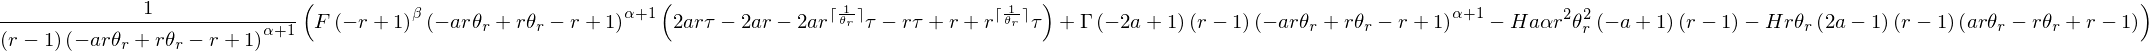

In [23]:
jacobian = sym.diff(x * (1 - x) * (tools.utility(s=1, x=x) - tools.utility(s=0, x=x)), x).expand().simplify()
jacobian.subs({x: sym.Symbol("a")})

# All poachers are selective



The condition is:
    
$$J(1) > 0$$

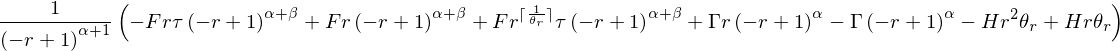

In [24]:
jacobian.subs({x: 1}).expand().simplify()

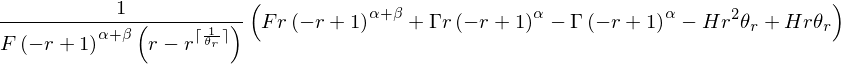

In [25]:
lower_bound = sym.solveset(jacobian.subs({x: 1}).expand().simplify(), tau).args[0]
lower_bound

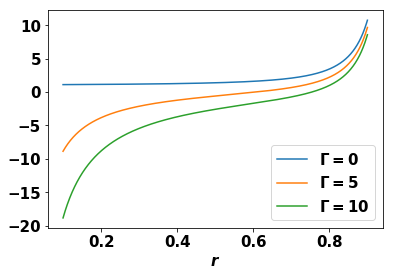

In [26]:
rs = np.linspace(.1, .9, 1000)
for g in (0, 5, 10):
    bounds = [lower_bound.subs(
        {F: 5, H: 50, r: r_val, alpha: 2, beta: .99, tau: 1.5, theta_r: 0.01, Gamma: g}
                            ) for r_val in rs]
    plt.plot(rs, bounds, label="$\Gamma={}$".format(g))
plt.xlabel("$r$")
plt.legend();

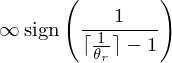

In [27]:
sym.limit(lower_bound, r, 1, dir="-")

In [28]:
sym.limit(lower_bound.subs({Gamma: 0}), r, 0)

# All poachers are indiscriminate

The condition is:
    
$$J(0) > 0$$

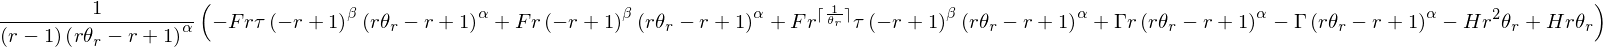

In [29]:
jacobian.subs({x: 0}).expand().simplify()

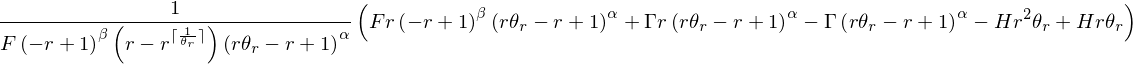

In [30]:
upper_bound = sym.solveset(jacobian.subs({x: 0}).expand().simplify(), tau).args[0]
upper_bound

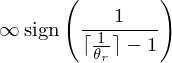

In [31]:
sym.limit(upper_bound, r, 1, dir="-")

# Possibility of a mixed population being stable

We first need to find \\(x^*\\) such that \\(u_1(x^*) = u_2(x^*)\\):

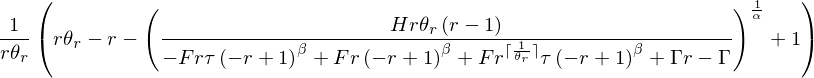

In [32]:
# Not using solveset
x_mixed = sym.solve(sym.fraction((tools.utility(1, x) - tools.utility(0, x)).expand().simplify())[0], x)[0]
x_mixed

In [33]:
# Need to check condition for which 0<x^*<1

In [34]:
x_mixed.subs({theta_r: .01, H: 192, F: 5, beta: .99, alpha:1.2, tau:1.5, r:.2, Gamma:0})

# Stable population

In [35]:
def is_converged(values, percent=10 ** -1, tol=10 ** -5):
    N = len(values)
    last = int(N * percent)
    return max(values[-last:]) - min(values[-last:]) < tol

def get_ts(exponent, number_of_points_scale=2):
    return np.linspace(0, 10 ** exponent, number_of_points_scale * 10 ** exponent)

def solve_till_convergence(scenario, starting_population=1 / 2, percent=10 ** -1, tol=10 ** -5):
    args = tuple(scenario[var] for var in ("F_v",  "H_v", "r", "alpha_v", "beta_v", "tau", "theta_r", "Gamma"))

    exponent = 1
    
    while exponent == 1 or (not is_converged(xs)):
        ts = get_ts(exponent)
        xs = odeint(func=dx, y0=[starting_population], t=ts, args=args)
        exponent += 1
        
    return ts, xs

In [36]:
data = []
starting_population = 1 / 2
scenarios = [{"F_v": 5, "H_v": 50, "r": .45, "alpha_v": 2, "beta_v": .99, "tau": 2, "theta_r": .05, "Gamma": 0},
             {"F_v": 5, "H_v": 50, "r": .4, "alpha_v": 2.5, "beta_v": .99, "tau": 1.8, "theta_r": .05, "Gamma": 0},
             {"F_v": 5, "H_v": 25, "r": .45, "alpha_v": 2, "beta_v": .99, "tau": 2, "theta_r": .05, "Gamma": 0},
             {"F_v": 5, "H_v": 25, "r": .4, "alpha_v": 2.5, "beta_v": .99, "tau": 1.8, "theta_r": .05, "Gamma": 0},
             {"F_v": 5, "H_v": 25, "r": .99, "alpha_v": 2, "beta_v": .99, "tau": 2, "theta_r": .05, "Gamma": 4},
             {"F_v": 5, "H_v": 25, "r": .99, "alpha_v": 2.5, "beta_v": .99, "tau": 1.8, "theta_r": .05, "Gamma": 4},
            ]

In [37]:
for scenario in scenarios:
    print(lower_bound.subs(scenario))

(-r + 1)**(-alpha - beta)*(F*r*(-r + 1)**(alpha + beta) + Gamma*r*(-r + 1)**alpha - Gamma*(-r + 1)**alpha - H*r**2*theta_r + H*r*theta_r)/(F*(r - r**ceiling(1/theta_r)))
(-r + 1)**(-alpha - beta)*(F*r*(-r + 1)**(alpha + beta) + Gamma*r*(-r + 1)**alpha - Gamma*(-r + 1)**alpha - H*r**2*theta_r + H*r*theta_r)/(F*(r - r**ceiling(1/theta_r)))
(-r + 1)**(-alpha - beta)*(F*r*(-r + 1)**(alpha + beta) + Gamma*r*(-r + 1)**alpha - Gamma*(-r + 1)**alpha - H*r**2*theta_r + H*r*theta_r)/(F*(r - r**ceiling(1/theta_r)))
(-r + 1)**(-alpha - beta)*(F*r*(-r + 1)**(alpha + beta) + Gamma*r*(-r + 1)**alpha - Gamma*(-r + 1)**alpha - H*r**2*theta_r + H*r*theta_r)/(F*(r - r**ceiling(1/theta_r)))
(-r + 1)**(-alpha - beta)*(F*r*(-r + 1)**(alpha + beta) + Gamma*r*(-r + 1)**alpha - Gamma*(-r + 1)**alpha - H*r**2*theta_r + H*r*theta_r)/(F*(r - r**ceiling(1/theta_r)))
(-r + 1)**(-alpha - beta)*(F*r*(-r + 1)**(alpha + beta) + Gamma*r*(-r + 1)**alpha - Gamma*(-r + 1)**alpha - H*r**2*theta_r + H*r*theta_r)/(F*(r - r**c

In [38]:
def numeric_lower_bound(scenario, lower_bound=lower_bound):
    return lower_bound.subs({
        alpha: scenario["alpha_v"], 
        r: scenario["r"],
        beta: scenario["beta_v"],
        F: scenario["F_v"],
        Gamma: scenario["Gamma"],
        theta_r: scenario["theta_r"],
        H: scenario["H_v"],
                            })

In [39]:
numeric_lower_bound(scenario), scenario["tau"]

In [40]:
number_of_points = 1000

variables = ("tau", "Gamma", "r")
linspaces = (np.linspace(.5, 2.5, number_of_points), 
             np.linspace(0, 8, number_of_points),
             np.linspace(0.01, .99, number_of_points), 
             )
x_labels = (r"$\tau$", "$\Gamma$", "$r$",)
stable_population_data_path = "../data/main.csv"

In [41]:
for base_scenario in scenarios:
    for i, (variable, linspace, x_label) in enumerate(zip(variables, linspaces, x_labels)):
        for value in linspace:
            scenario = {key: value for key, value in base_scenario.items()}
            scenario[variable] = value
            
            ts, xs = solve_till_convergence(scenario=scenario)
            scenario["x"] = xs[-1][0]
            scenario["lower_bound"] = numeric_lower_bound(scenario=scenario)
            data.append(scenario)

df = pd.DataFrame(data)
df.head()
df.to_csv(stable_population_data_path)

Test that the theoretic condition is true:

In [42]:
df = pd.read_csv(stable_population_data_path)
~(np.isclose(df["x"], 1, rtol=10 ** -4))

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [43]:
all(
    (
        (
            (np.isclose(df["x"], 1, rtol=10 ** -4)) &  # and
            (df["tau"] > df["lower_bound"])
        ) |  # or
        (
            (~(np.isclose(df["x"], 1, rtol=10 ** -4))) &  # and
            (df["tau"] <= df["lower_bound"])
        )
    )
)

True

In [44]:
with open("../list_of_scenarios.tex", "w") as f:
    for i, scenario in enumerate(scenarios):
        f.write("\item Scenario {i}: \(H={H_v}\)  \(r={r}\) \(\\alpha={alpha_v}\), \(\\tau={tau}\), \(\\Gamma={Gamma}\)\n".format(i=i +1, **scenario))

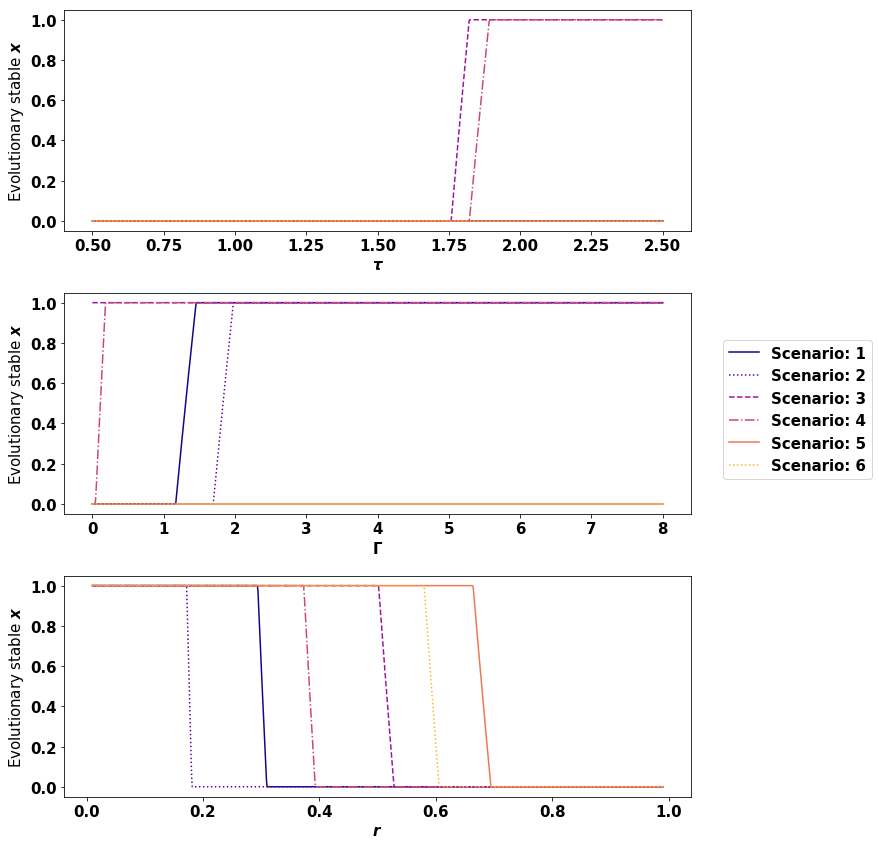

In [45]:
linestyles = ['-', ':', '--', '-.', '-', ':']
colors = list(matplotlib.cm.plasma(np.linspace(0, 1, len(scenarios) + 1)))

fig, axarr =  plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

for i, (variable, x_label) in enumerate(zip(variables, x_labels)):
    ax = axarr[i]
    for j, (scenario, color, linestyle) in enumerate(zip(scenarios, colors, linestyles)):
        index = np.all(np.array([df[key] == value for key, value in scenario.items() if key != variable]), axis=0)
        sorted_df = df[index].sort_values(variable)
        ax.plot(sorted_df[variable], sorted_df["x"], color=color, linestyle=linestyle, label="Scenario: {}".format(j + 1))
        ax.set_xlabel(x_label)
        ax.set_ylabel("Evolutionary stable $x$")

ax.legend(bbox_to_anchor=(1.3, 2.1))
plt.tight_layout()
plt.savefig('../images/steady_populations.pdf', bbox_inches='tight')